## Partie 1 - Préparation des données

### Étape 1.1 : Chargement et exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

np.random.seed(42)
n = 500

df = pd.DataFrame(
    {
        "age": np.random.randint(15, 23, n),
        "study_time": np.random.randint(1, 5, n),
        "failures": np.random.choice([0, 1, 2, 3], n, p=[0.6, 0.25, 0.1, 0.05]),
        "absences": np.random.randint(0, 40, n),
        "parental_support": np.random.choice(
            ["none", "low", "medium", "high", "very high"], n
        ),
        "extracurricular": np.random.choice(["yes", "no"], n),
        "internet": np.random.choice(["yes", "no"], n, p=[0.7, 0.3]),
        "health": np.random.randint(1, 6, n),
        "freetime": np.random.randint(1, 6, n),
        "goout": np.random.randint(1, 6, n),
    }
)

df["passed"] = (
    (df["study_time"] >= 3) * 0.4
    + (df["failures"] == 0) * 0.3
    + (df["absences"] < 10) * 0.2
    + (df["parental_support"].isin(["high", "very high"])) * 0.1
    + np.random.uniform(0, 0.3, n)
) > 0.5
df["passed"] = df["passed"].astype(int)

print(df.head())
print(f"\nDimensions : {df.shape}")
print(f"Taux de réussite : {df['passed'].mean():.1%}")

   age  study_time  failures  absences parental_support extracurricular  \
0   21           3         1        11        very high              no   
1   18           1         0        15              low              no   
2   19           1         0        23             high              no   
3   21           4         1        18             none              no   
4   17           3         1         7             none              no   

  internet  health  freetime  goout  passed  
0      yes       3         4      4       1  
1      yes       2         3      4       0  
2      yes       2         4      3       1  
3      yes       1         1      2       1  
4       no       3         5      3       1  

Dimensions : (500, 11)
Taux de réussite : 67.0%


### Étape 1.2 : Prétraitement

In [52]:
# Séparation features / target
X = df.drop("passed", axis=1).copy()
y = df["passed"].copy()

# TODO : Identifiez les colonnes numériques et catégorielles
num_features = X.select_dtypes(include=np.number).columns.to_list()
cat_features = X.select_dtypes(include="object").columns.to_list()

print("Numeric features: ", num_features)
print("Categoric features: ", cat_features)

# TODO : Créez un pipeline de prétraitement
num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
    ]
)

# TODO : Séparez en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, stratify=y
)

Numeric features:  ['age', 'study_time', 'failures', 'absences', 'health', 'freetime', 'goout']
Categoric features:  ['parental_support', 'extracurricular', 'internet']


## Partie 2 - Entraînement du modèle

### Étape 2.1 : Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# TODO : Créez un pipeline complet (preprocessor + RandomForestClassifier)
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# TODO : Entraînez le modèle et évaluez-le sur le test set
rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Classification report : ")
print(classification_report(y_test, y_pred))

Accuracy :  0.85
Classification report : 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        33
           1       0.87      0.91      0.89        67

    accuracy                           0.85       100
   macro avg       0.84      0.82      0.83       100
weighted avg       0.85      0.85      0.85       100



## Partie 3 - Feature Importance

### Étape 3.1 : Extraction des importances

In [54]:
# Récupération des noms de toutes les features après transformation
rf_clf = rf_pipeline.named_steps["classifier"]
preprocessor_fitted = rf_pipeline.named_steps["preprocessor"]

ohe = preprocessor_fitted.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_features).tolist()
all_feature_names = num_features + cat_feature_names

# TODO : Récupérez les importances et affichez-les triées par ordre décroissant
rf_importances = rf_clf.feature_importances_
indices = np.argsort(rf_importances)[::-1]

sorted_names = [all_feature_names[i] for i in indices]
sorted_imp = rf_importances[indices]

for name, imp in zip(sorted_names, sorted_imp):
    print(f"{name:<30}| {imp:.3f}")

study_time                    | 0.317
absences                      | 0.143
failures                      | 0.136
age                           | 0.067
goout                         | 0.063
health                        | 0.059
freetime                      | 0.055
parental_support_low          | 0.033
parental_support_high         | 0.018
extracurricular_no            | 0.018
parental_support_medium       | 0.017
extracurricular_yes           | 0.016
internet_yes                  | 0.015
parental_support_none         | 0.015
internet_no                   | 0.015
parental_support_very high    | 0.015


### Étape 3.2 : Visualisation des importances

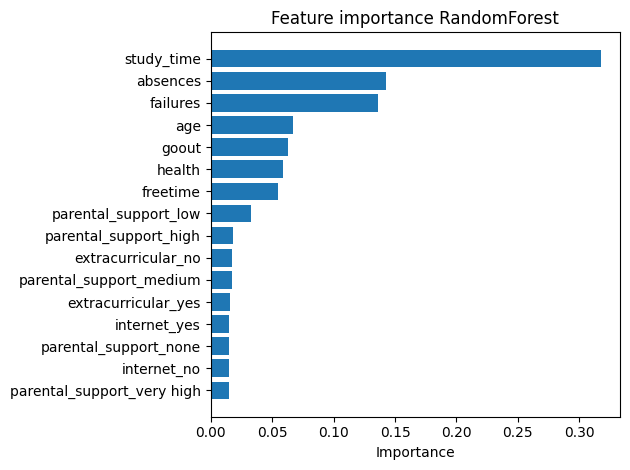

In [55]:
# TODO : Reproduisez un graphique en barres horizontales
fig, axes = plt.subplots()

axes.barh(range(len(sorted_imp)), sorted_imp[::-1])
axes.set_yticks(range(len(sorted_imp)))
axes.set_yticklabels(sorted_names[::-1], fontsize=10)
axes.set_xlabel("Importance", fontsize=10)
axes.set_title("Feature importance RandomForest")

plt.tight_layout()

### Étape 3.3 : Comparaison Decision Tree vs Random Forest

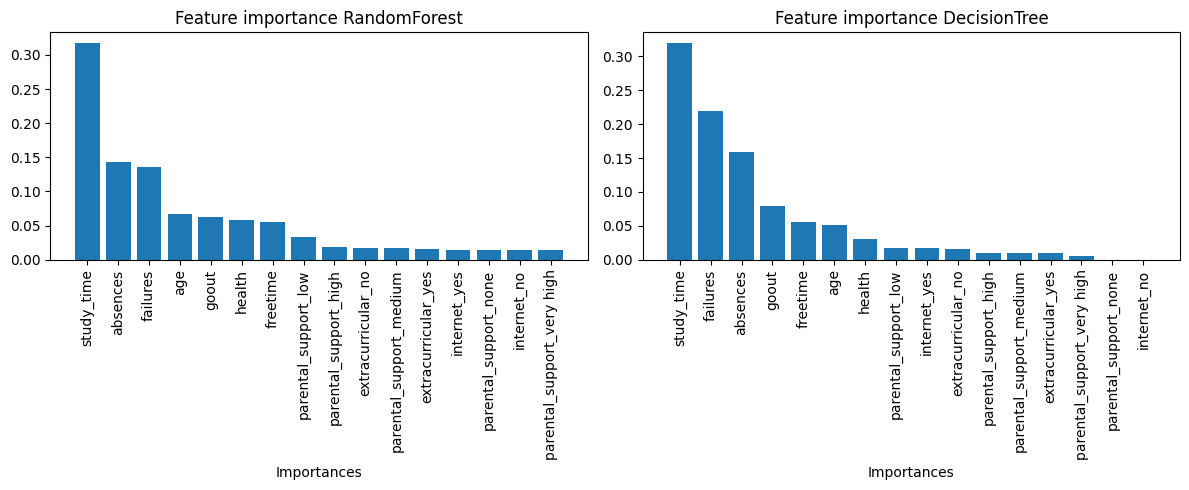

In [56]:
from sklearn.tree import DecisionTreeClassifier

# TODO : Entraînez un Decision Tree avec le même preprocesseur
dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

dt_pipeline.fit(X_train, y_train)

# TODO : Récupérez ses importances
dt_clf = dt_pipeline.named_steps["classifier"]
dt_importances = dt_clf.feature_importances_

# TODO : Affichez les deux bar charts côte à côte (1 ligne, 2 colonnes)
# pour comparer DT vs RF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (imp, title) in zip(
    axes, [(rf_importances, "RandomForest"), (dt_importances, "DecisionTree")]
):
    idx = np.argsort(imp)[::-1]
    ax.bar(range(len(imp)), imp[idx])
    ax.set_xticks(range(len(imp)))
    ax.set_xticklabels([all_feature_names[i] for i in idx], fontsize=10, rotation=90)
    ax.set_xlabel("Importances")
    ax.set_title(f"Feature importance {title}")

plt.tight_layout()

## Partie 4 - Analyse SHAP

### Étape 4.1 : Calcul des valeurs SHAP

In [57]:
import shap

# TODO : Transformez les données avec le preprocesseur
X_train_prep = rf_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_prep = rf_pipeline.named_steps["preprocessor"].transform(X_test)

# TODO : Entraînez un Random Forest sans Pipeline sur les données transformées
rf_shap = RandomForestClassifier(n_estimators=100, random_state=42)
rf_shap.fit(X_train_prep, y_train)

# TODO : Créez un TreeExplainer et calculez les valeurs SHAP
explainer = shap.TreeExplainer(rf_shap)
shap_values_raw = explainer.shap_values(X_test_prep)

# Gestion de la compatibilité SHAP
if shap_values_raw.ndim == 3:
    shap_values = [shap_values_raw[:, :, i] for i in range(shap_values_raw.shape[2])]
else:
    shap_values = shap_values_raw

print(f"Shape des valeurs SHAP (classe 1) : {shap_values[1].shape}")

Shape des valeurs SHAP (classe 1) : (100, 16)


### Étape 4.2 : Summary Plot (vue globale)

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4300\2698179697.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


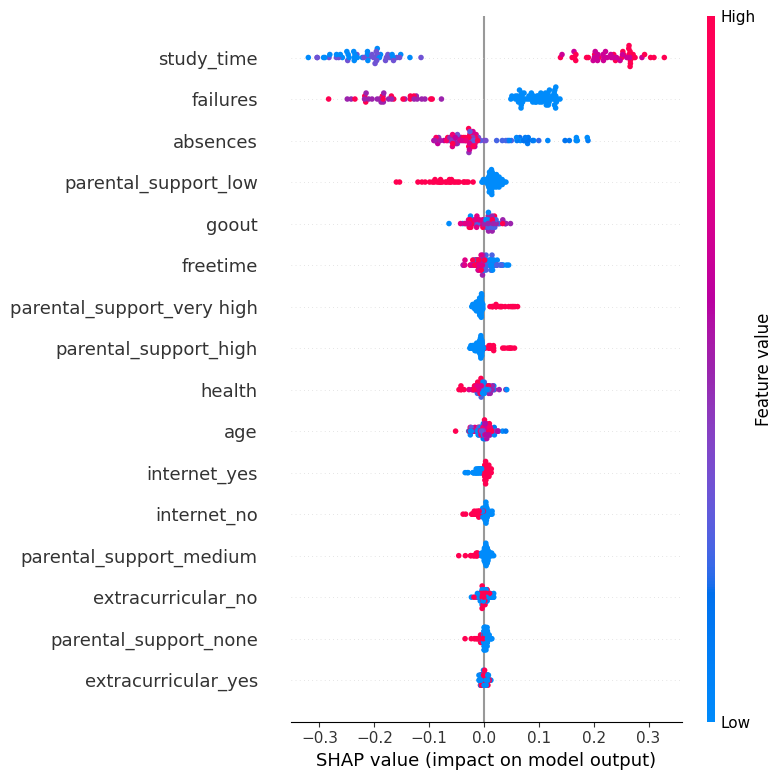

In [58]:
# TODO : Affichez le summary plot SHAP pour la classe 1 (élève qui réussit)
shap.summary_plot(
    shap_values[1], X_test_prep, feature_names=all_feature_names, plot_type="dot"
)

### Étape 4.3 : Explication locale (Waterfall Plot)

age                           | -0.244
study_time                    | -0.408
failures                      | -0.654
absences                      | -0.967
health                        | 0.666
freetime                      | 0.038
goout                         | -1.450
parental_support_high         | 1.000
parental_support_low          | 0.000
parental_support_medium       | 0.000
parental_support_none         | 0.000
parental_support_very high    | 0.000
extracurricular_no            | 0.000
extracurricular_yes           | 1.000
internet_no                   | 0.000
internet_yes                  | 1.000

True label: 1
Predict label: 1 | Proba: 0.67


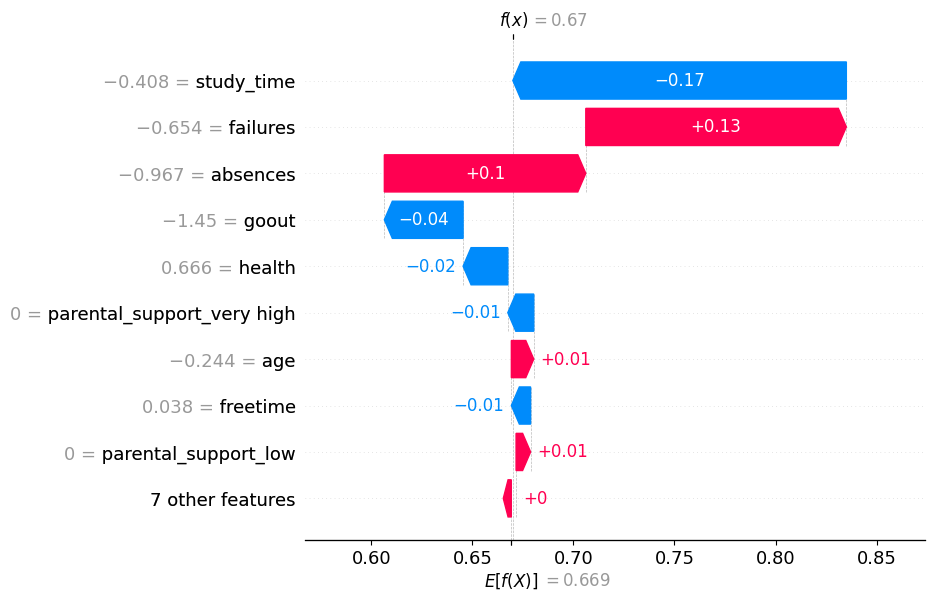

In [61]:
# TODO : Choisissez un élève du test set (par exemple sample_idx = 5)
# Affichez ses caractéristiques
sample_idx = 5
instance = X_test_prep[sample_idx]
true_label = y_test.iloc[sample_idx]
pred_proba = rf_shap.predict_proba([instance])[0][1]
pred_label = rf_shap.predict([instance])[0]

for feature_name, value in zip(all_feature_names, instance):
    print(f"{feature_name:<30}| {value:0.3f}")
print()
print(f"True label: {true_label}")
print(f"Predict label: {pred_label} | Proba: {pred_proba}")

# TODO : Créez et affichez le waterfall plot pour cet élève
expected_val = explainer.expected_value

shap_exp = shap.Explanation(
    values=shap_values[1][sample_idx],
    base_values=expected_val[1],
    data=instance,
    feature_names=all_feature_names,
)

shap.waterfall_plot(shap_exp)

### Étape 4.4 (Bonus) : Comparer deux élèves

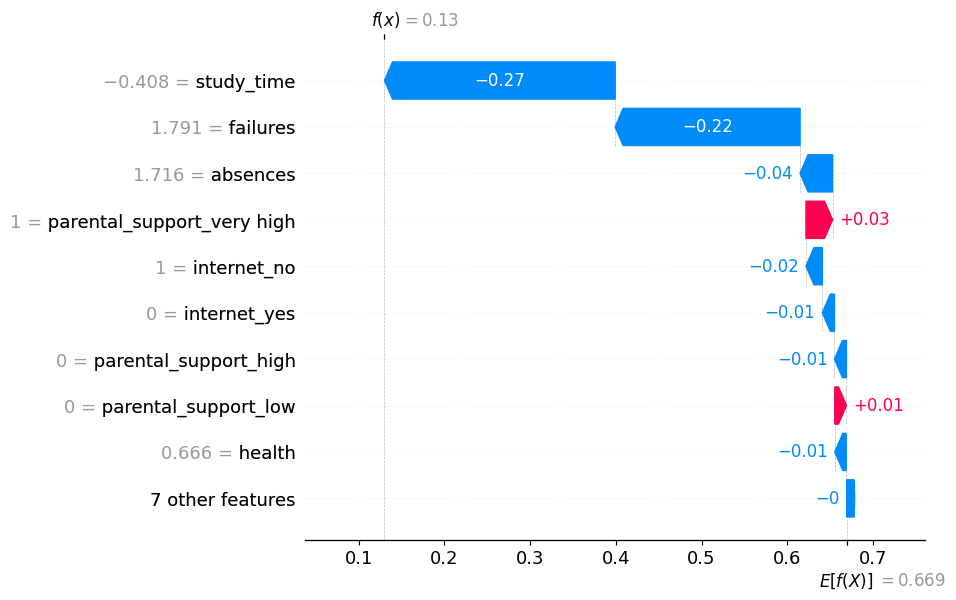

In [66]:
sample_idx_other = 3
instance_other = X_test_prep[sample_idx_other]
expected_val_other = explainer.expected_value

shap_exp_other = shap.Explanation(
    values=shap_values[1][sample_idx_other],
    base_values=expected_val_other[1],
    data=instance_other,
    feature_names=all_feature_names,
)

shap.waterfall_plot(shap_exp_other)